In [1]:
#! pip install scikit-image
%pip install ultralytics
%pip install roboflow

import cv2
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from PIL import Image
import glob
#import imutils

from ultralytics import YOLO

# for filename in glob.glob('data/CROSS_X-F1-B1_P880043_20200625111459_225-2/*.png'):
#   frame=cv2.imread(filename)
#   # Normalize the image
#   img_normalized = cv2.normalize( frame, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F )
#   cv2.imshow("orig",frame)
#   cv2.imshow( "norm", img_normalized)
#   cv2.waitKey(0)
# # close all windows
# cv2.destroyAllWindows()

  Using cached roboflow-1.1.18-py3-none-any.whl (69 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
  Using cached opencv_python_headless-4.8.0.74-cp37-abi3-win_amd64.whl (38.0 MB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
  Using cached supervision-0.18.0-py3-none-any.whl (86 kB)
  Using cached python_magic-0.4.27-py2.py3-none-any.whl (13 kB)
  Using cached matplotlib-3.8.2-cp39-cp39-win_amd64.whl (7.6 MB)

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1


In [16]:
# Normalize and save images
for filename in glob.glob('./data/WALK_Y-F0-B1_P287619_20200619084759_250/*.png'):
    frame=cv2.imread(filename)
    # Normalize the image
    img_normalized = cv2.normalize(frame, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    cv2.imwrite(f'./data/normalizedImages/{filename}', img_normalized)


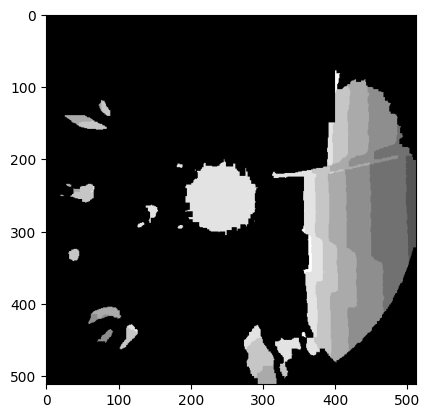

In [105]:
directory = 'data/CROSS_X-F1-B1_P880043_20200625111459_225-2'
file_root = 'CROSS_X-F1-B1_P880043_20200625111459_225_cs001_'

# directory = 'data/PASS-2LBO_X-F3-B0_P848995_20210303145112_275'
# file_root = 'PASS-2LBO_X-F3-B0_P848995_20210303145112_275_cs013_'

# directory = 'data/FLOOR_Y-F1-B0_P220533_20201203141353_275'
# file_root = 'FLOOR_Y-F1-B0_P220533_20201203141353_275_cs010_'

def generate_background(path):
    image = cv2.imread(f'{directory}/{file_root}{path:05}.png')

    # Save normalized image
    cv2.imwrite(f'{directory}/norm_{file_root}{path:05}.png', image)
   
    # threshold the image
    # ret, image = cv2.threshold(image, 0.45, 1, cv2.THRESH_BINARY)

    # closing
    kernel = np.ones((7,7),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    image[0:150, 200:400] = 0
    image[400:512, 170:240] = 0

    # image[200:300, 300:500] = 0

    return image

background = generate_background(112)
plt.imshow(background)

In [2]:
# vizualization

def preprocess(frame):
    image = cv2.imread(frame)

    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

    result = cv2.absdiff(image, background)

    # remove small noise
    kernel = np.ones((3,3),np.uint8)
    result = cv2.erode(result,kernel,iterations = 2)

    # threshold
    # ret, result = cv2.threshold(result, 0.05, 1, cv2.THRESH_BINARY)

    # closing
    kernel = np.ones((3,3),np.uint8)
    result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel, iterations=3)

    # extract only one chanel

    return result

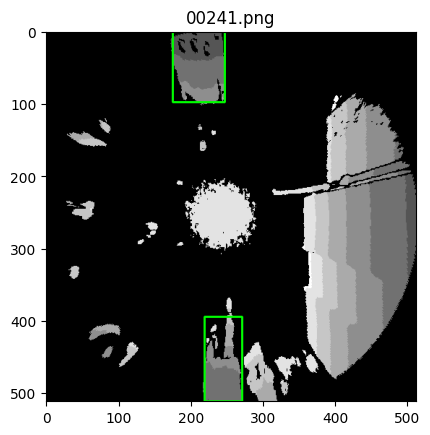

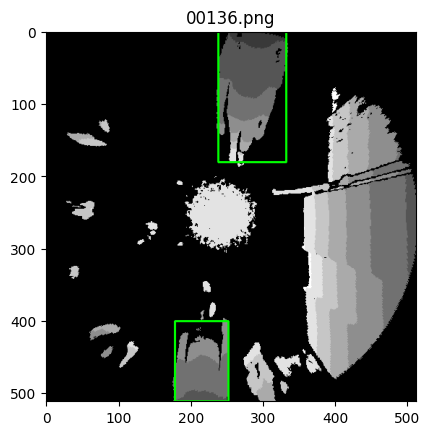

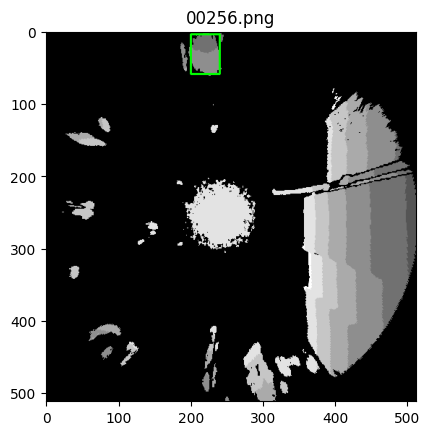

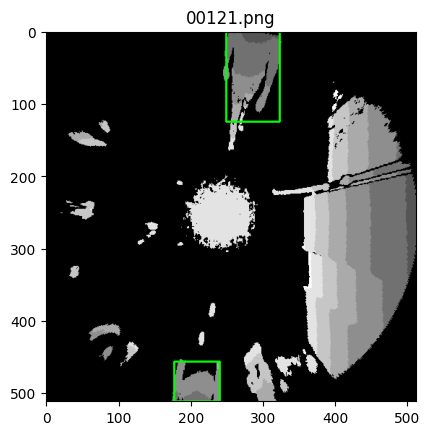

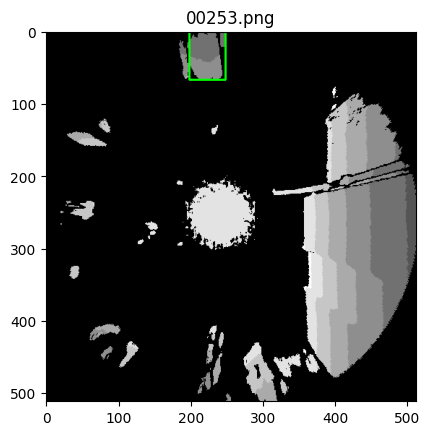

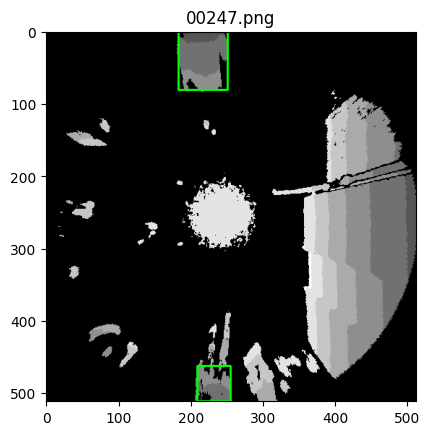

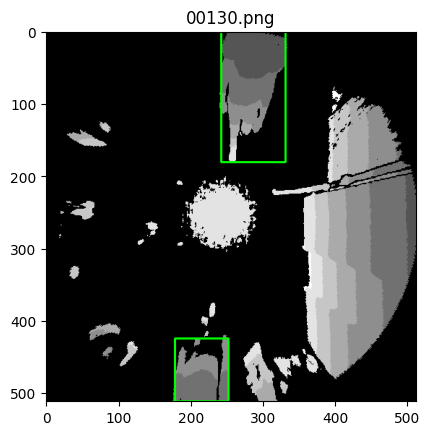

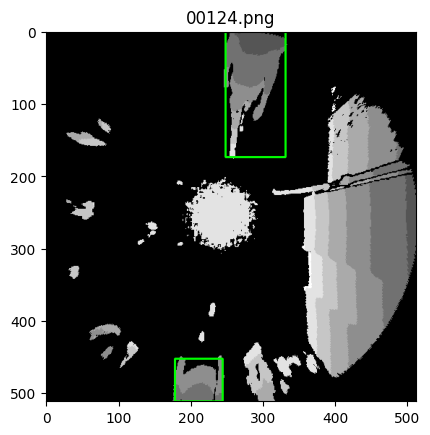

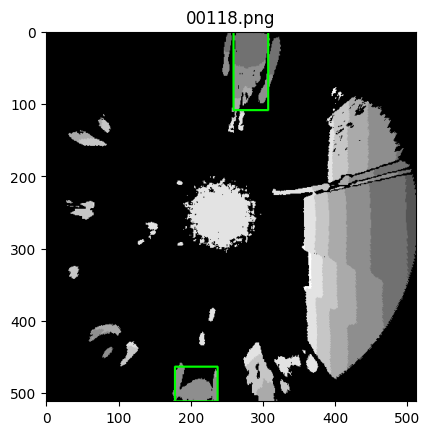

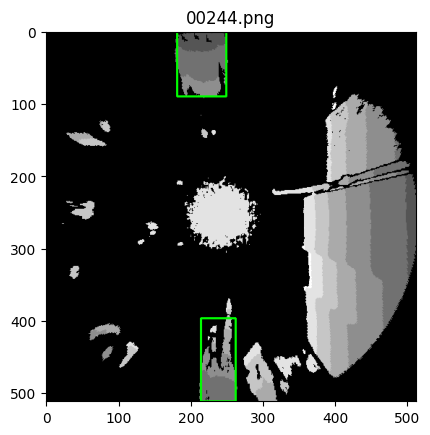

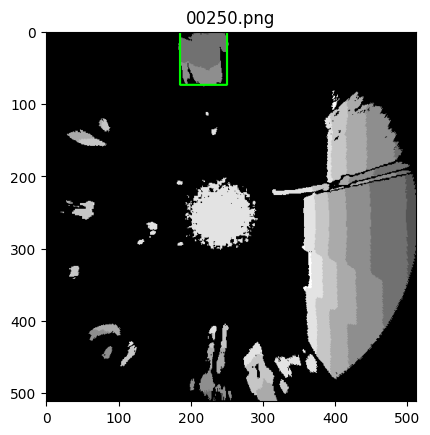

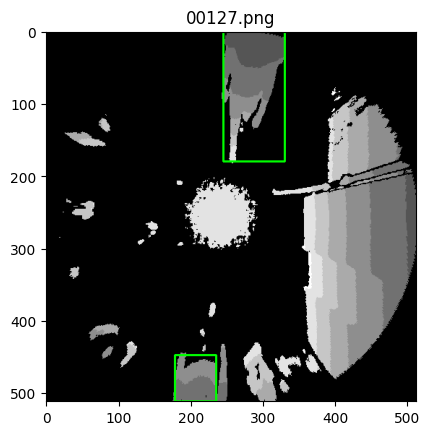

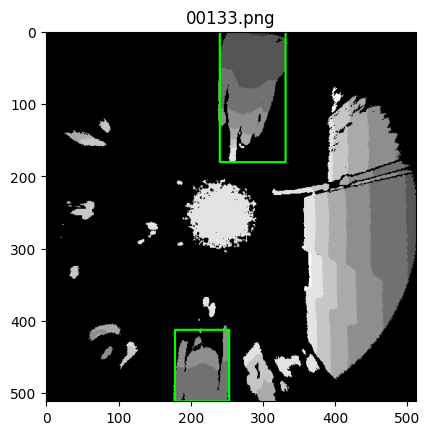

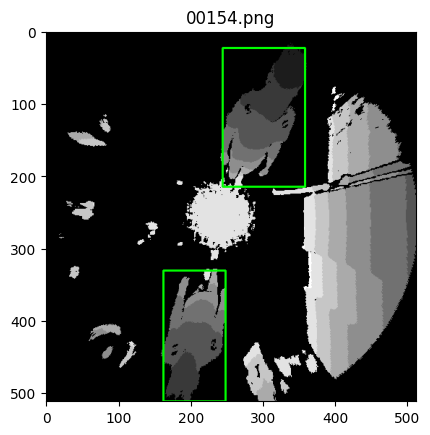

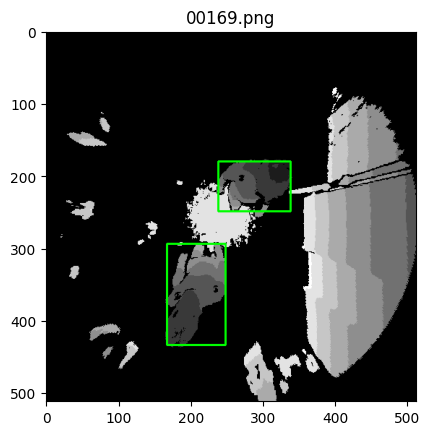

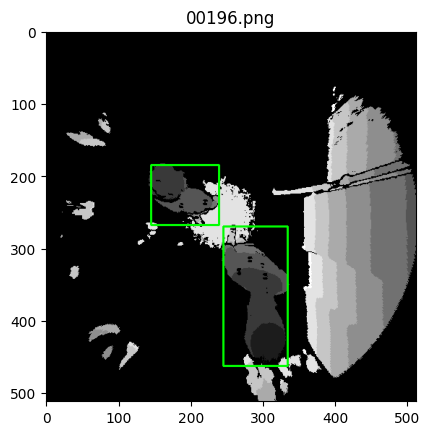

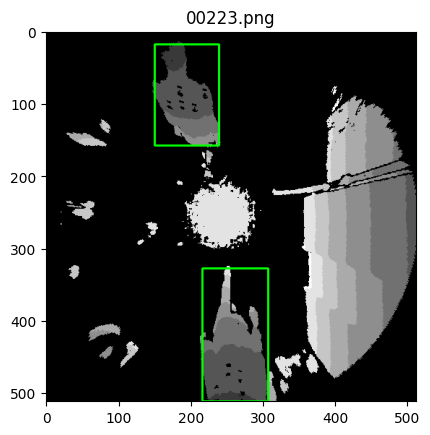

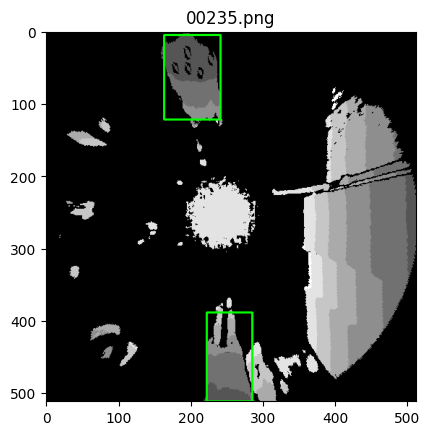

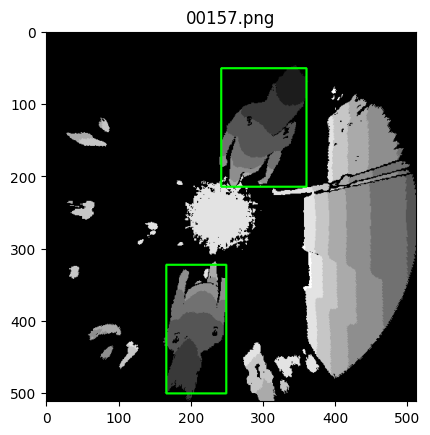

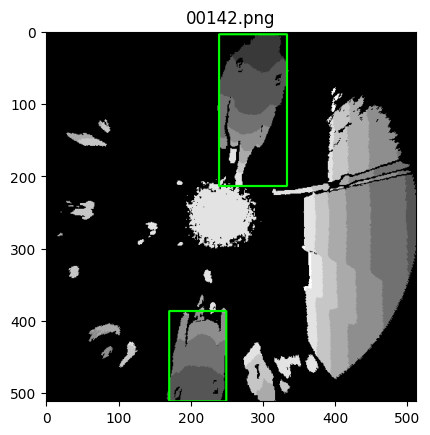

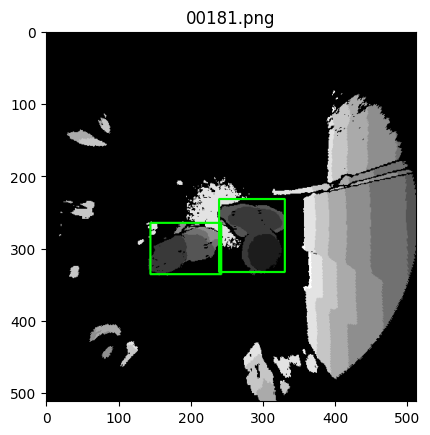

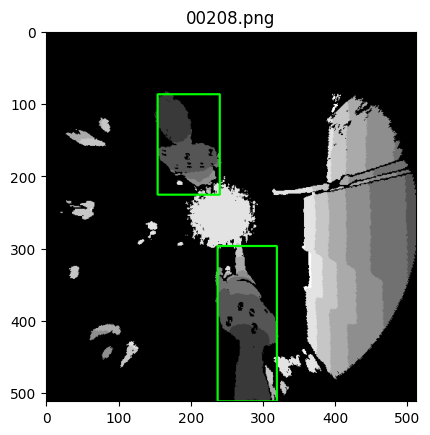

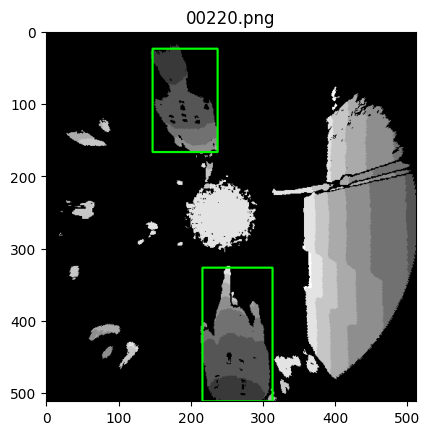

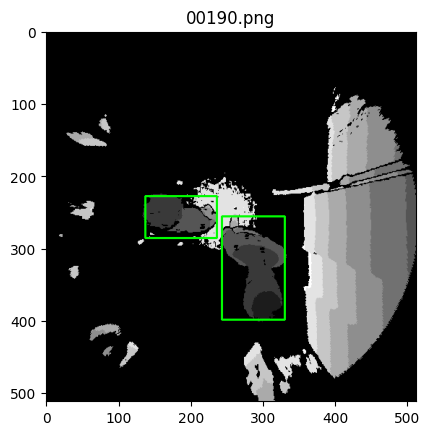

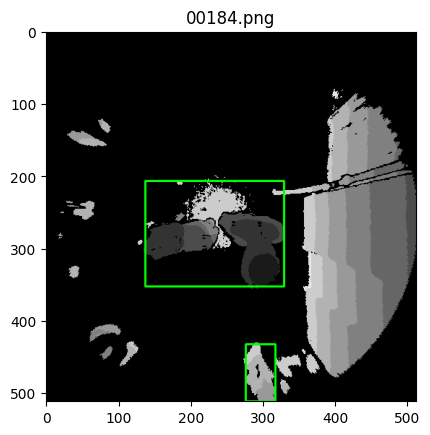

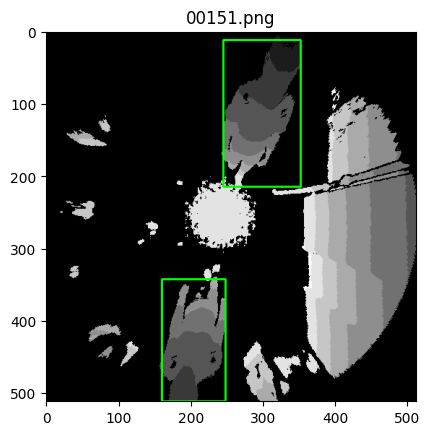

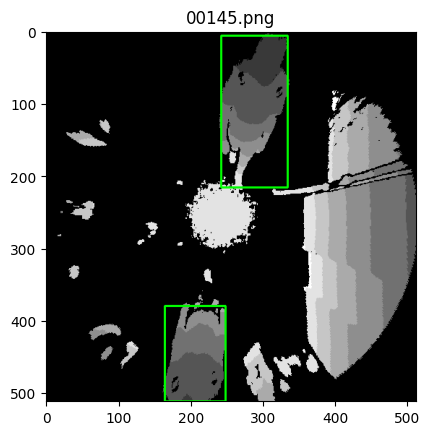

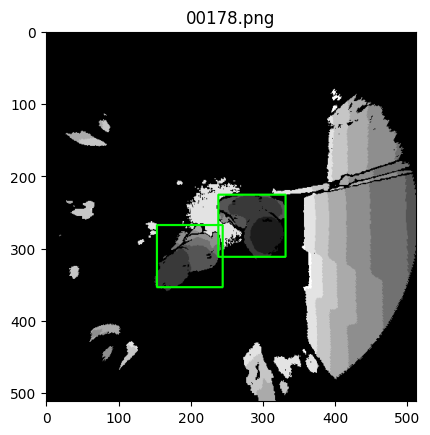

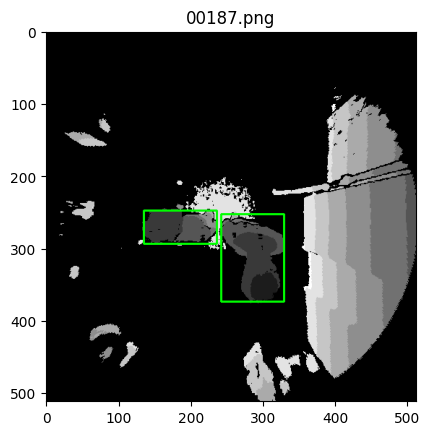

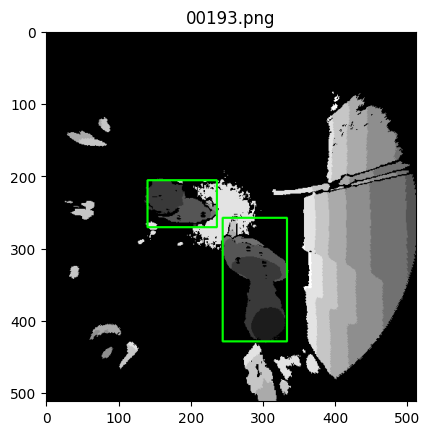

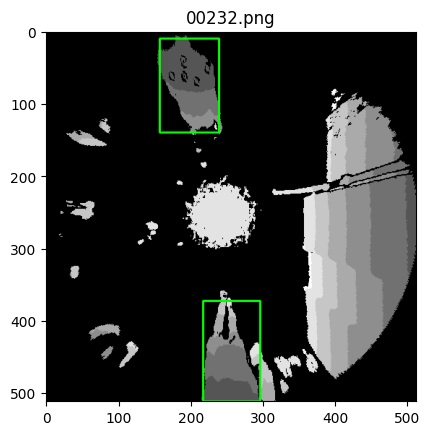

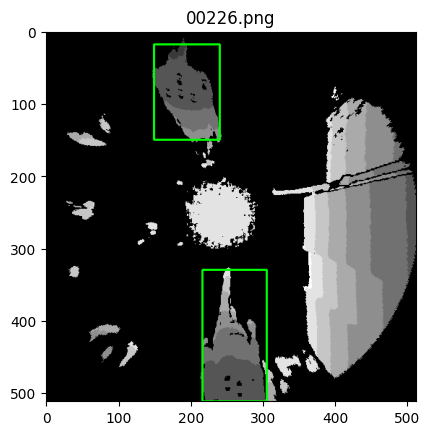

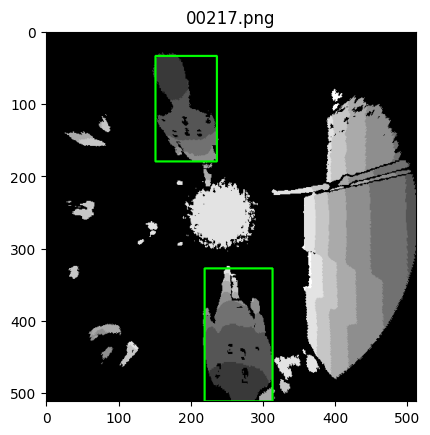

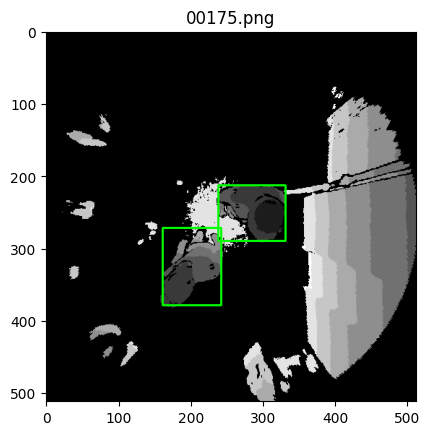

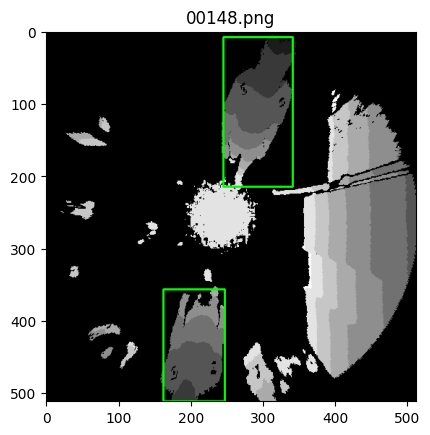

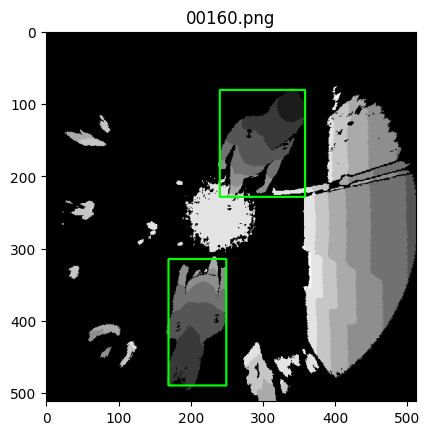

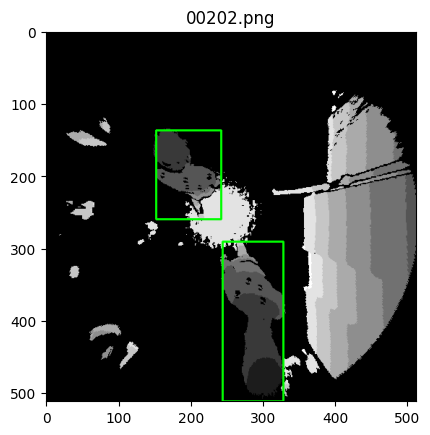

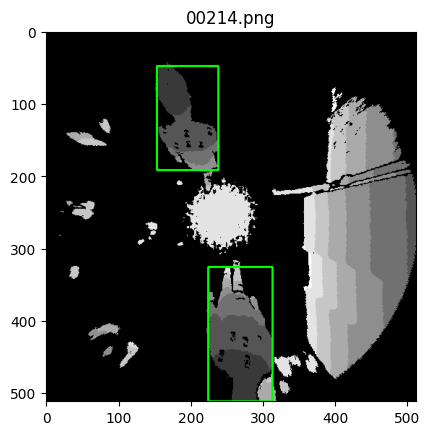

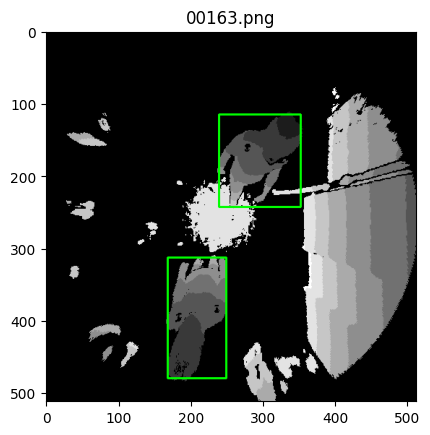

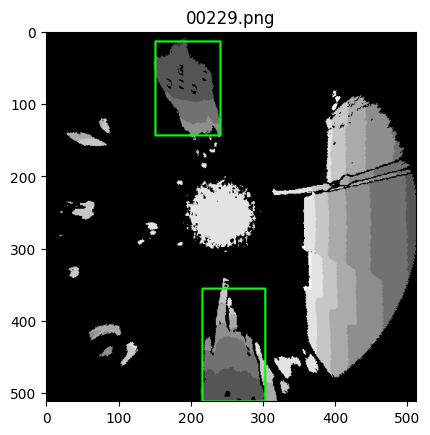

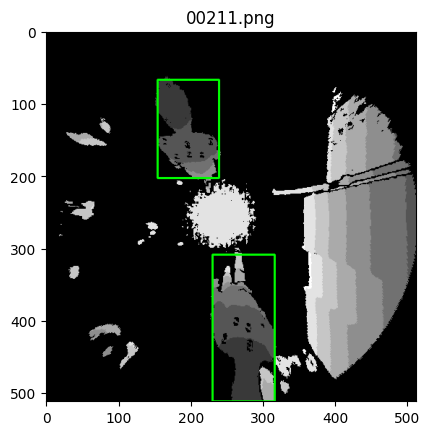

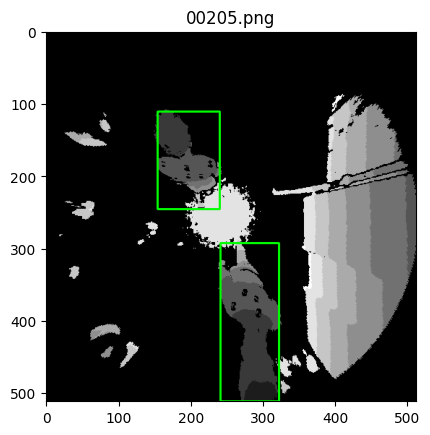

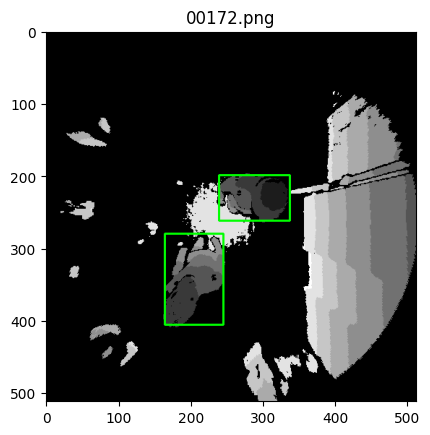

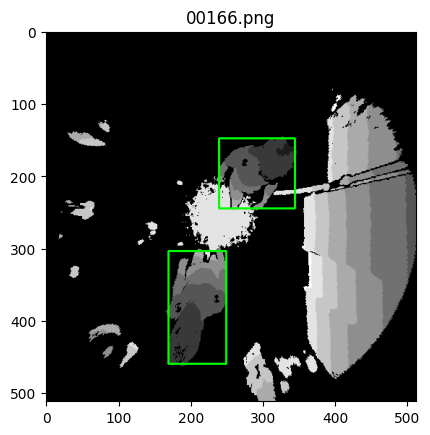

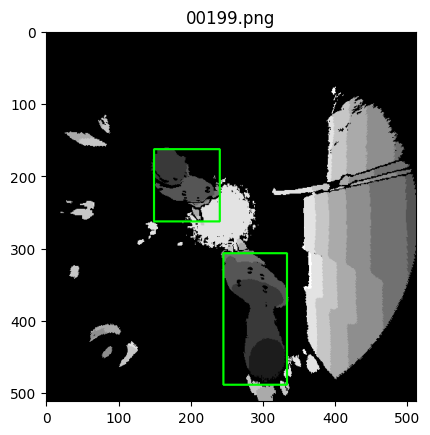

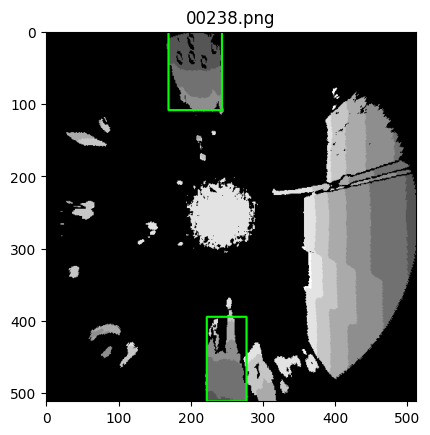

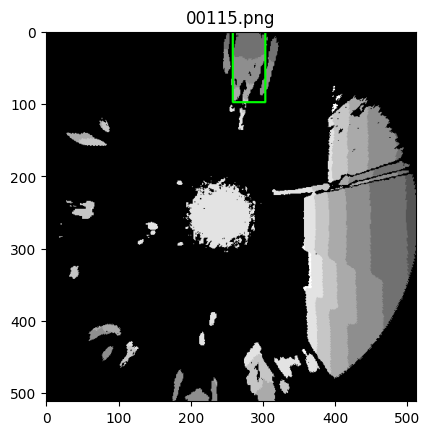

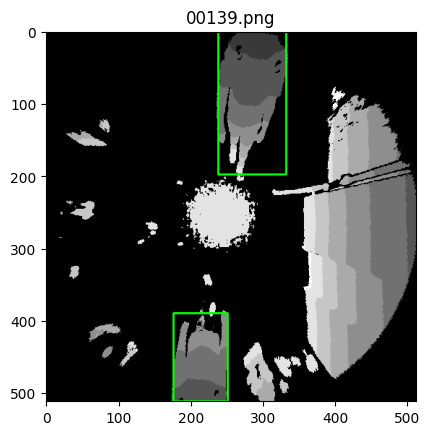

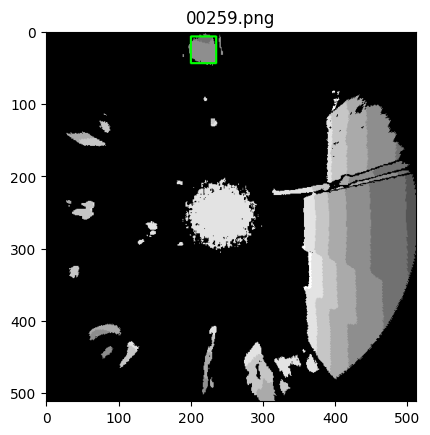

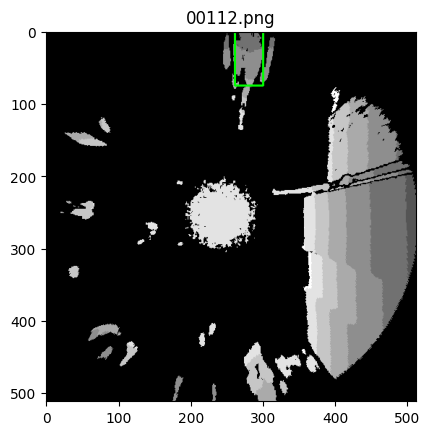

In [107]:
for filename in glob.glob(f'{directory}/*.png'):
    
    result = preprocess(filename)

    # select only the largest contour
    contours, hierarchy = cv2.findContours(result[:,:,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # sort contours by area
    contours = [c for c in contours if cv2.contourArea(c) > 500 and cv2.contourArea(c) < 15000]

    result = result.astype(np.uint8)

    # draw the largest contours
    cv2.drawContours(result, contours, -1, (0, 255, 0), 2)

    image = cv2.imread(filename)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

    # draw the bounding box
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)

    plt.imshow(image)
    plt.title(filename.split('_')[-1])
    plt.show()
    # cv2.imshow('result', result)
    # cv2.waitKey(0)

In [3]:
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

from roboflow import Roboflow
rf = Roboflow(api_key="dF1uYnQARlUa1X6hEGcj")
project = rf.workspace("lab3perceptionai").project("perceptionfinalproject")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.8, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to perceptionFinalProject-1 in yolov8:: 100%|██████████| 232/232 [00:00<00:00, 1695.58it/s]


In [24]:
results = model.train(data=dataset, epochs = 25,imgsz=224)

Ultralytics YOLOv8.1.8 🚀 Python-3.9.12 torch-2.0.1+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yolov8, epochs=25, time=None, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

RuntimeError: Dataset 'yolov8' error  'yolov8' does not exist

In [15]:
print(project.id)

lab3perceptionai/perceptionfinalproject


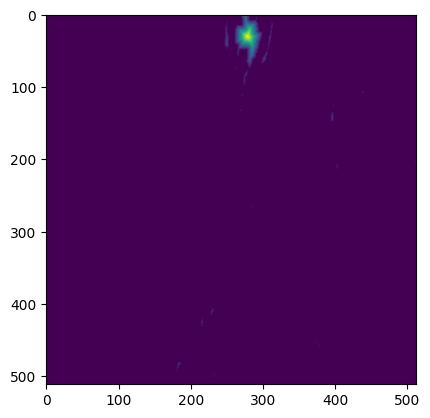

[ 30 278]
[ 32 279]
[483 184]
[ 70 281]
[ 91 274]
[108 438]
[208 403]
[137 396]
[ 95 273]
[451 373]
[140 395]
[410 230]
[132 268]
[226 359]
[264 285]


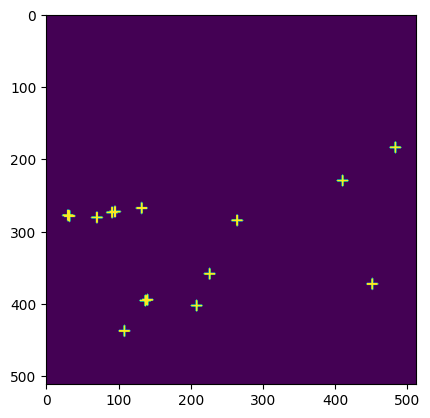

[0]


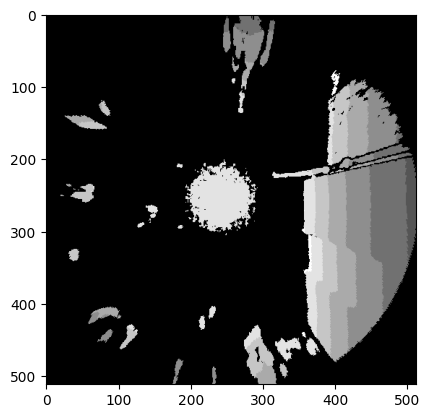

In [110]:
# whaterhsed

result = preprocess(f'{directory}/{file_root}00112.png')

# apply distance transform
D = ndimage.distance_transform_edt(result[:,:,0])

plt.imshow(D)
plt.show()

# find peaks in the distance map
localMax = peak_local_max(D, min_distance=20, labels=result[:,:,0])

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
markerType = cv2.MARKER_CROSS
markerSize = 15
thickness = 2

img = np.zeros((512, 512), dtype=np.uint8)
for marker in localMax:
    print(marker)
    cv2.drawMarker(img, marker, 255, markerSize=markerSize, thickness=thickness)

plt.imshow(img)
plt.show()

labels = watershed(-D, markers=img, mask=result[:,:,0])

print(np.unique(labels))

# loop over the unique labels returned by the Watershed
# algorithm

image = cv2.imread(f'{directory}/{file_root}00112.png')
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue

    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(result[:, :, 0].shape, dtype="uint8")
    mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# show the output image
plt.imshow(image)
plt.show()

In [16]:
# importing boxes from csv file
import pandas as pd

df = pd.read_csv('data/CROSS_X-F1-B1_P880043_20200625111459_225/boxes_2d.csv', sep=';')
max(df['y_min'])

409.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


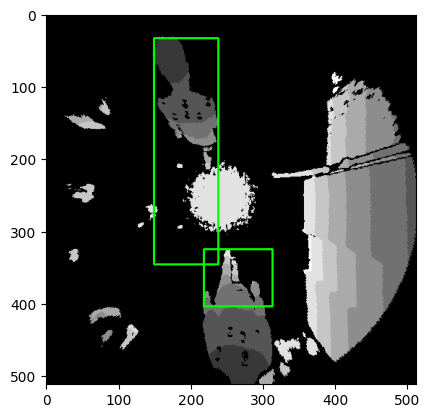

In [83]:
# drawing the box in the image
frame = 217
image = cv2.imread(f'data/CROSS_X-F1-B1_P880043_20200625111459_225-2/CROSS_X-F1-B1_P880043_20200625111459_225_cs001_{frame:05}.png')

# Normalize the image
image = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(image)
rect_image = image.copy()
# plt.imshow(img_normalized)

# draing the box
boxes = df.loc[df['frame'] == frame].values
# print(label, xmin, ymin, xmax, ymax, area)
for box in boxes:
    xmin, ymin, xmax, ymax =  map(int, box[2:6])
    # ymin, ymax =  abs(ymin-512), abs(ymax-512)
    cv2.rectangle(rect_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

plt.imshow(rect_image)

TypeError: Cannot cast array data from dtype('float32') to dtype('int64') according to the rule 'safe'

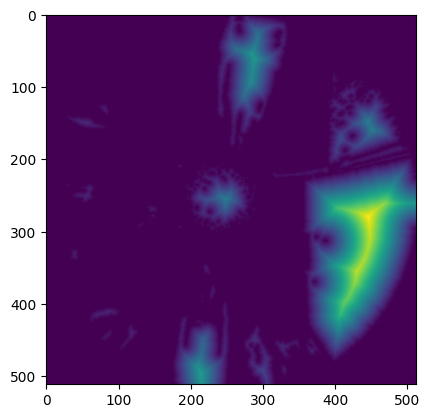

In [78]:
# limiarization
# image = cv2.imread('data/CROSS_X-F1-B1_P880043_20200625111459_225-2/CROSS_X-F1-B1_P880043_20200625111459_225_cs001_00112.png')

# shifted = cv2.pyrMeanShiftFiltering(image*255, 21, 51)
gray = cv2.cvtColor(image*255, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
# plt.imshow(thresh)

# cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
# print("[INFO] {} unique contours found".format(len(cnts)))
# # loop over the contours
# for (i, c) in enumerate(cnts):
# 	# draw the contour
# 	((x, y), _) = cv2.minEnclosingCircle(c)
# 	cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),
# 		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# 	cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)

# visualize the distance map
plt.imshow(D)

localMax = peak_local_max(D, min_distance=20, labels=thresh)
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))


# # Normalize the image

In [8]:
! pip install ultralytics -q

from ultralytics import YOLO

model = YOLO('yolov8n.pt')
results = model.train(data="/content/personDetection-1/data.yaml", epochs = 25,imgsz=224)

⚠️ Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n.pt...


######################################################################## 100.0%


Ultralytics YOLOv8.1.8 🚀 Python-3.11.0 torch-2.1.2 CPU (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/personDetection-1/data.yaml, epochs=25, time=None, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

RuntimeError: Dataset '/content/personDetection-1/data.yaml' error ❌ '/content/personDetection-1/data.yaml' does not exist

In [ ]:

cap = cv2.VideoCapture('/content/drive/MyDrive/KITTI-16-raw.mp4') #à modifier selon vos conditions

#read the video file until "q" is pressed
while( cap.isOpened() ):
    ret, frame = cap.read()
    #frame = cv2.resize(frame, (smt, smt), interpolation=cv.INTER_LINEAR) # add resize command to fit model size
    
    #Applying OpenCv thresholding https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
    ret, thresh = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    th2 = cv.adaptiveThreshold(frame,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)
    th3 = cv.adaptiveThreshold(frame,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)

    c = cv2.waitKey(1)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/KITTI-16-raw.mp4') #à modifier selon vos conditions

#read the video file until "q" is pressed
while( cap.isOpened() ):
    ret, frame = cap.read()
    #frame = cv2.resize(frame, (smt, smt), interpolation=cv.INTER_LINEAR) # add resize command to fit model size
    results = model.predict(frame,conf=0.1)  # predict on an image

    if len(results) > 0:
        for r in results:
            res_plotted = results[ 0 ].plot() # get results
            box = r.boxes.cpu() #get bounding boxes
            box_sz = box.xyxy.numpy() # coordinates

            cv2.imshow(res_plotted)
            break

    c = cv2.waitKey(1)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()
     